In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

# Forward

A parameteric neural network (PNN) can be help a NN learn to interpolate between important phase space quantities. 
However, a downwise to these networks is that each phase space point that is underconsideration must be evaluated on both signal and background

Instead of training the PNN on all available phase space points, we can imagine sectioning of the phase space in some way that in each section of phase space the network is as optimal as it can be for that section.
Since the relationship between the phase space and target is not known, it may be possible to train a second NN to section the phase space in a way that is optimal for the PNN.

## First concept
The first concept that seemed to work well is using an AutoEncoder to compress that parameteric features down to a 1D latent space.
Where each feature in the latent space corresponds to a section of the phase space.
This latent space embedding can then be used to train the PNN.

To evaluate the network, we can specify which of the sections of the latent space we want to evaluate on. 

In [2]:
from utils.genprodUtils.generators import Generator
from utils.genprodUtils.kinematics import two_body_decay, random_decay

class Signal(Generator):

    def __init__(self, m_x, m_y):
        assert m_x > 2 * m_y , "m_x must be greater than 2 * m_y"
        self.m_x , self.m_y = m_x, m_y

        super().__init__(
            dict(
                pt=lambda n : np.random.lognormal(np.log(100), 1, n),
                eta=lambda n : np.random.uniform(-2.5, 2.5, n),
                phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
                mass=lambda n : np.random.normal(m_x, 0.1*m_x, n),
            )
        )

    def valid(self, event):
        self.y = np.random.lognormal( np.log(self.m_y), 0.2, size=(len(event), 2) )
        self.j = np.random.lognormal( np.log(10), 0.5, size=(len(event), 2, 2) )
        mask = (event.mass > np.sum(self.y, axis=1)) & np.all( self.y > np.sum(self.j, axis=-1), axis=1 )

        self.y = self.y[mask]
        self.j = self.j[mask]

        return mask

    
    def physics(self, event):
        y1, y2 = two_body_decay(event, *self.y.T)

        y1j1, y1j2 = two_body_decay(y1, *self.j[:,0].T)
        y2j1, y2j2 = two_body_decay(y2, *self.j[:,1].T)

        jet = ak.concatenate([ j[:,None] for j in [y1j1, y1j2, y2j1, y2j2] ], axis=1)
        jet = jet[ak.argsort(-jet.pt, axis=1)]

        return dict(
            jet=jet,
            y1=y1,
            y2=y2,
        )

In [3]:
class Background(Generator):
    def __init__(self):
        super().__init__(
            dict(
                pt=lambda n : np.random.lognormal(np.log(100), 1, n),
                eta=lambda n : np.random.uniform(-2.5, 2.5, n),
                phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
                mass=lambda n : np.random.lognormal( np.log(400), 1, n),
            )
        )

    def valid(self, event):
        self.y = np.random.lognormal( np.log(50), 1, size=(len(event), 2) )
        self.j = np.random.lognormal( np.log(10), 0.5, size=(len(event), 2, 2) )
        mask = (event.mass > np.sum(self.y, axis=1)) & np.all( self.y > np.sum(self.j, axis=-1), axis=1 )

        self.y = self.y[mask]
        self.j = self.j[mask]

        return mask

    def physics(self, event):
        y1, y2 = two_body_decay(event, *self.y.T)

        y1j1, y1j2 = two_body_decay(y1, *self.j[:,0].T)
        y2j1, y2j2 = two_body_decay(y2, *self.j[:,1].T)

        jet = ak.concatenate([ j[:,None] for j in [y1j1, y1j2, y2j1, y2j2] ], axis=1)
        jet = jet[ak.argsort(-jet.pt, axis=1)]

        return dict(
            jet=jet,
            y1=y1,
            y2=y2,
        )

In [41]:
MX = np.arange(100, 1000, 50)
MY = np.arange( 50,  500, 50)
masses = np.stack(np.meshgrid(MX, MY), axis=-1).reshape(-1, 2)
mask = masses[:,0] > 2 * masses[:,1]
masses = masses[mask]
gen_sig = { tuple(mass):Signal(*mass) for mass in masses }
efficiency = np.array([ gen.efficiency() for gen in gen_sig.values() ])

(<Figure size 650x650 with 2 Axes>,
 <AxesSubplot:>,
 <utils.plotUtils.graph2d.Graph2D at 0x7fbd836b3ca0>)

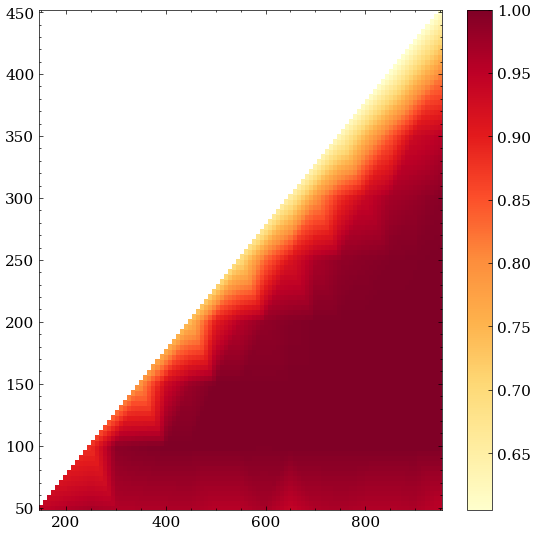

In [43]:
graph2d_array(
    *masses.T, efficiency, colorbar=True, interp=True,
)

In [44]:
gen_bkg = Background()

In [47]:
class sig_tree(ParallelMethod):
    def start(self, args):
        mass, gen = args
        return dict(mass=mass, gen=gen)

    def run(self, mass, gen):
        return dict(tree=Tree.from_ak(gen(int( 5000 / len(gen_sig) )), sample=f'mass={mass}', is_signal=True, mass=mass))
    
    def end(self, args, tree):
        return tree
sig_tree = sig_tree()

import multiprocess as mp

with mp.Pool(8) as pool:
    training_signal = ObjIter(list(gen_sig.items())).parallel_apply(sig_tree, report=True, pool=pool)

0it [00:00, ?it/s]       | 0/81 [00:00<?, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


sig_tree:   0%|          | 0/81 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [7]:
training_signal = ObjIter([ Tree.from_ak(gen(int( 5000 / len(gen_sig) )), sample=f'mass={m}', is_signal=True, mass=m) for m, gen in gen_sig.items() ])
training_bkg = ObjIter([ Tree.from_ak(gen_bkg(5000), sample='bkg', color='lightgrey') ])

0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]

[WARNING] unable to open any files with filelist
           []


In [8]:
signal = ObjIter([ Tree.from_ak(gen(int( 5000 / len(gen_sig) )), sample=f'mass={m}', is_signal=True, mass=m) for m, gen in gen_sig.items() ])
bkg = ObjIter([ Tree.from_ak(gen_bkg(5000), sample='bkg', color='lightgrey') ])

0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]

[WARNING] unable to open any files with filelist
           []


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


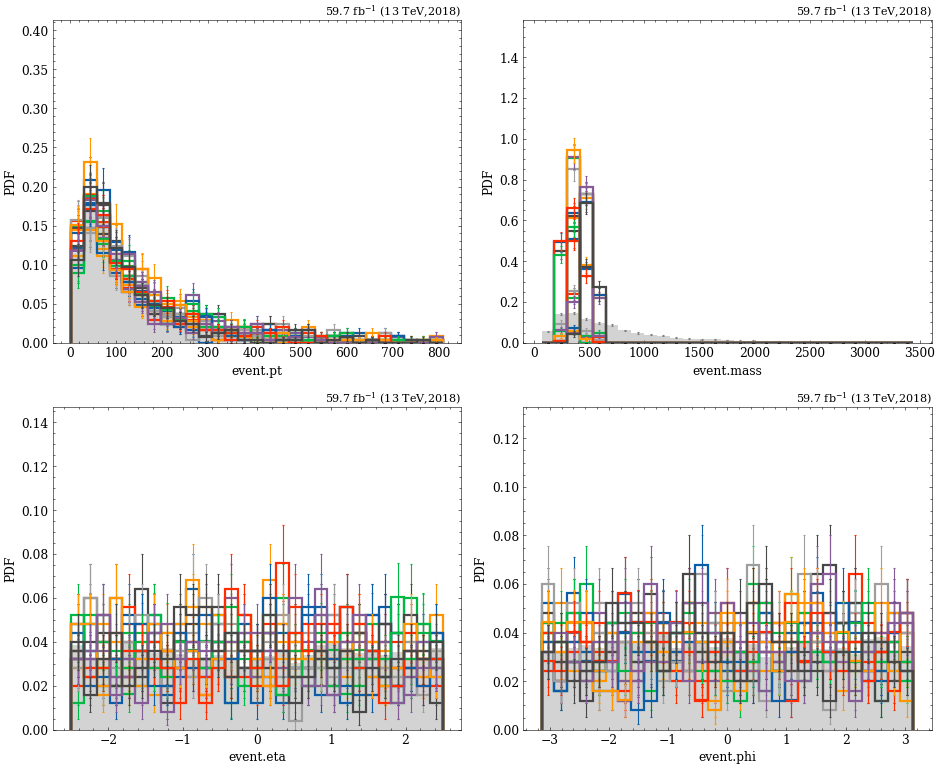

In [9]:
study.quick(
    training_signal + training_bkg,
    varlist=['event.pt','event.mass','event.eta','event.phi'],
    efficiency=True,
)

100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


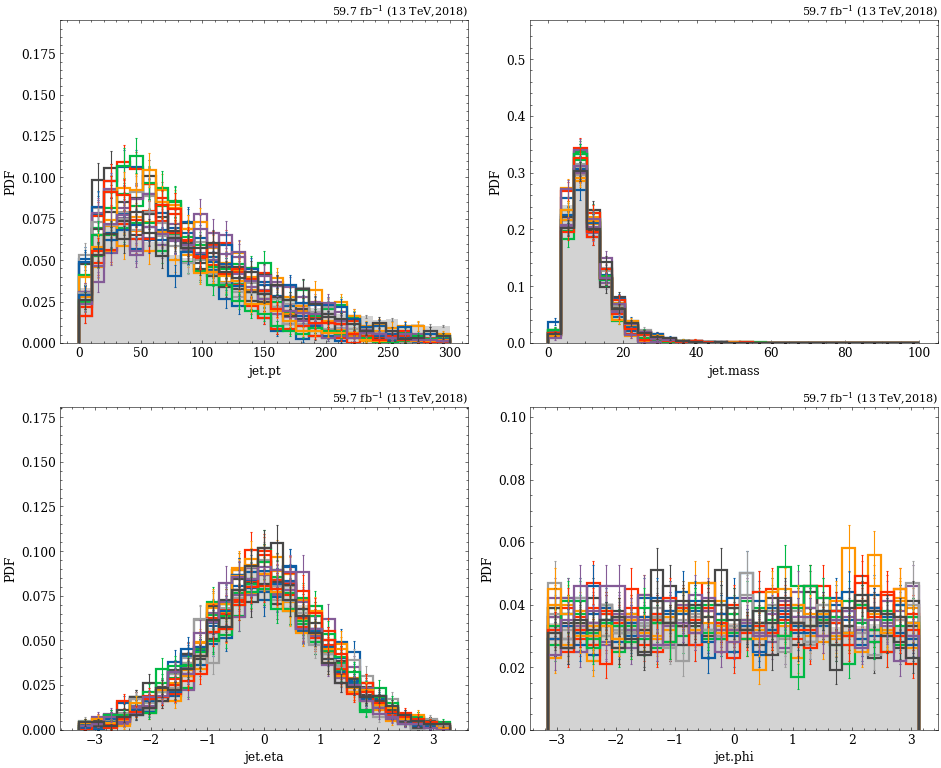

In [10]:
study.quick(
    training_signal + training_bkg,
    varlist=['jet.pt','jet.mass','jet.eta','jet.phi'],
    binlist=[(0,300,30),(0,100,30)],
    efficiency=True,
)

In [26]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, trees):
        self.trees = trees
        self.length = sum( len(tree) for tree in trees )

        self.inputs = np.concatenate([ self.get_inputs(tree) for tree in trees ], axis=0)
        self.targets = np.concatenate([ self.get_targets(tree) for tree in trees ], axis=0)

        self.parameters = np.concatenate([ self.get_parameters(tree) for tree in trees ], axis=0)

        is_bkg = self.targets == 0
        random_parameters = self.parameters[np.random.choice(np.where(~is_bkg)[0], np.sum(is_bkg), replace=True)]
        self.parameters[is_bkg] = random_parameters

    @property
    def input_dims(self):
        return self.inputs.shape[1]
    
    @property
    def parameter_dims(self):
        return self.parameters.shape[1]

    def __getitem__(self, idx):
        return dict(
            inputs=self.inputs[idx],
            targets=self.targets[idx],
            parameters=self.parameters[idx],
        )

    def __len__(self):
        return self.length

    def get_inputs(self, tree):
        feature_names = ['jet.pt', 'jet.eta', 'jet.phi', 'jet.mass']
        features = list()

        for feature in feature_names:
            feature = tree[feature]
            if feature.ndim == 1:
                feature = feature[:,None]

            features.append(feature)

        features = ak.concatenate(features, axis=1).to_numpy().astype(np.float32)
        return features

    def get_parameters(self, tree):
        mx, my = tree.__dict__.get('mass', (-1, -1))
        mx = np.ones(len(tree), dtype=np.float32) * mx
        my = np.ones(len(tree), dtype=np.float32) * my
        return np.stack([mx, my], axis=1)

    def get_targets(self, tree):
        return np.ones(len(tree), dtype=np.int64) * tree.is_signal
    
dataset = Dataset(training_signal + training_bkg)

In [27]:
loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
for batch in loader:
    break

In [28]:
import pytorch_lightning as pl
import torchmetrics

In [29]:
from typing import Any
    
class ParameterAutoEncoder(pl.LightningModule):
    def __init__(self, n_fts, embedding=[16, 32], n_emb=2):
        super().__init__()

        self.n_fts = n_fts
        self.embedding = embedding
        self.n_emb = n_emb
        self.act = torch.nn.LeakyReLU()

        embedding = [n_fts] + embedding + [n_emb]

        self.feature_norm = torch.nn.BatchNorm1d(n_fts, affine=False)
        layers = [
                    layer
                    for n_in, n_out in zip(embedding[:-1], embedding[1:])
                    for layer in [ torch.nn.Linear(n_in, n_out), self.act ]
                ][:-1] + [ torch.nn.Softmax(dim=1) ]
        self.encoder = torch.nn.Sequential(*layers)

        layers = [
                    layer
                    for n_in, n_out in zip(embedding[::-1][:-1], embedding[::-1][1:])
                    for layer in [ torch.nn.Linear(n_in, n_out), self.act ]
                ][:-1]
        self.decoder = torch.nn.Sequential(*layers)

    def forward(self, x):
        x, embed = self.encode(x)
        xhat = self.decoder(embed)
        return x, embed, xhat

    def encode(self, x):
        x = self.feature_norm(x)
        embed = self.encoder(x)
        return x, embed

    def one_hot_encode(self, parameters):
        _, embed = self.encode(parameters)
        return self.one_hot(embed.argmax(dim=1))

    def one_hot(self, idx):
        idx = idx[:,None]
        one_hot = torch.zeros(len(idx), self.n_emb, device=self.device)
        one_hot.scatter_(1, idx, 1)
        return one_hot

    def step(self, parameters):
        x = parameters
        x, embed, xhat = self(x)

        mse_loss = torch.nn.functional.mse_loss(xhat, x)
        loss = mse_loss

        # max_loss = torch.nn.functional.mse_loss(embed, self.one_hot(torch.argmax(embed, axis=1)))
        # loss = loss + 0 * max_loss

        return dict(
            mse_loss = mse_loss,
            # max_loss = max_loss,
            loss = loss
        )
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch['parameters'])
        return loss

    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
class Classifier(pl.LightningModule):
    def __init__(self, n_fts, embedding=[32, 16], n_cls=2):
        super().__init__()

        self.n_fts = n_fts
        self.embedding = embedding
        self.n_cls = n_cls
        self.act = torch.nn.LeakyReLU()

        embedding = [n_fts] + embedding + [n_cls]
        layers = [torch.nn.BatchNorm1d(n_fts, affine=False)] + [
                    layer
                    for n_in, n_out in zip(embedding[:-1], embedding[1:])
                    for layer in [ torch.nn.Linear(n_in, n_out), self.act ]
                ][:-1] + [ torch.nn.Softmax(dim=1) ]
        self.mlp = torch.nn.Sequential(*layers)
        

    def forward(self, x):
        return self.mlp(x)

class AutoPNN(pl.LightningModule):
    def __init__(self, input_dims, parameter_dims, parameter_embedding=[16, 32], parameter_n_emb=2, input_embedding=[16, 32], classifier_embedding=[32, 16], classifier_n_cls=2):
        super().__init__()

        self.input_dims = input_dims
        self.parameter_dims = parameter_dims

        self.act = torch.nn.LeakyReLU()

        self.autoencoder = None
        if parameter_n_emb > 0:
            self.autoencoder = ParameterAutoEncoder(parameter_dims, embedding=parameter_embedding, n_emb=parameter_n_emb)

            parameter_embedding = [parameter_n_emb] + input_embedding
            layers = [
                        layer
                        for n_in, n_out in zip(parameter_embedding[:-1], parameter_embedding[1:])
                        for layer in [ torch.nn.Linear(n_in, n_out), self.act ]
                    ][:-1]
            self.parameter_embedding = torch.nn.Sequential(*layers)

        input_embedding = [input_dims] + input_embedding
        layers = [
                    layer
                    for n_in, n_out in zip(input_embedding[:-1], input_embedding[1:])
                    for layer in [ torch.nn.Linear(n_in, n_out), self.act ]
                ][:-1]
        self.input_embedding = torch.nn.Sequential(*layers)

        self.classifier = Classifier(input_embedding[-1], embedding=classifier_embedding, n_cls=classifier_n_cls)

        self.auroc = torchmetrics.AUROC('multiclass', num_classes=classifier_n_cls)


    def forward(self, inputs, parameters):
        inputs = self.input_embedding(inputs)

        if self.autoencoder is not None:
            _, parameters = self.autoencoder.encode(parameters)
            inputs = inputs + self.parameter_embedding(parameters)

        return self.classifier(inputs)

    def predict(self, inputs, section=None):
        inputs = self.input_embedding(inputs)

        if self.autoencoder is not None:
            section = self.autoencoder.one_hot(section)
            inputs = inputs + self.parameter_embedding(section)

        return self.classifier(inputs)

    def training_step(self, batch, batch_idx):
        inputs, parameters, targets = batch['inputs'], batch['parameters'], batch['targets']

        yhat = self(inputs, parameters)
        class_loss = torch.nn.functional.cross_entropy(yhat, targets)
        self.log('class_loss', class_loss, on_epoch=True, on_step=False, prog_bar=True)
        loss = class_loss

        auroc = self.auroc(yhat, targets)
        self.log('auroc', auroc, on_epoch=True, on_step=False, prog_bar=True)

        if self.autoencoder is not None:
            ae_losses = self.autoencoder.step(parameters)

            for key, value in ae_losses.items():
                if key == 'loss': continue
                self.log(key, value, on_epoch=True, on_step=False, prog_bar=True)

            loss = loss + ae_losses['loss']

        self.log('loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     inputs, parameters, targets = batch['inputs'], batch['parameters'], batch['targets']

    #     self.autoencoder.one_hot_encode(parameters)

    #     yhat = self(inputs, parameters)

    #     auroc = self.auroc(yhat, targets)
    #     self.log('val_auroc', auroc, on_epoch=True, on_step=False, prog_bar=True)
    #     return loss

    
    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [30]:
nominal_model = AutoPNN(dataset.input_dims, dataset.parameter_dims, parameter_embedding=[16, 32], parameter_n_emb=0, input_embedding=[16, 32], classifier_embedding=[32, 16], classifier_n_cls=2)
trainer = pl.Trainer(max_epochs=10, accelerator='cpu')
trainer.fit(nominal_model, loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type            | Params
----------------------------------------------------
0 | act             | LeakyReLU       | 0     
1 | input_embedding | Sequential      | 816   
2 | classifier      | Classifier      | 1.6 K 
3 | auroc           | MulticlassAUROC | 0     
----------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [31]:
model = AutoPNN(dataset.input_dims, dataset.parameter_dims, parameter_embedding=[16, 32], parameter_n_emb=3, input_embedding=[16, 32], classifier_embedding=[32, 16], classifier_n_cls=2)
trainer = pl.Trainer(max_epochs=10, accelerator='cpu')
trainer.fit(model, loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                 | Params
-------------------------------------------------------------
0 | act                 | LeakyReLU            | 0     
1 | autoencoder         | ParameterAutoEncoder | 1.4 K 
2 | parameter_embedding | Sequential           | 608   
3 | input_embedding     | Sequential           | 816   
4 | classifier          | Classifier           | 1.6 K 
5 | auroc               | MulticlassAUROC      | 0     
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated mode

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


(<Figure size 960x400 with 3 Axes>,
 <AxesSubplot:ylabel='Events'>,
 HistoList<[<utils.plotUtils.histogram.Histo object at 0x7fbd9966d7c0>, <utils.plotUtils.histogram.Histo object at 0x7fbd9966d790>, <utils.plotUtils.histogram.Histo object at 0x7fbd9966da30>]>)

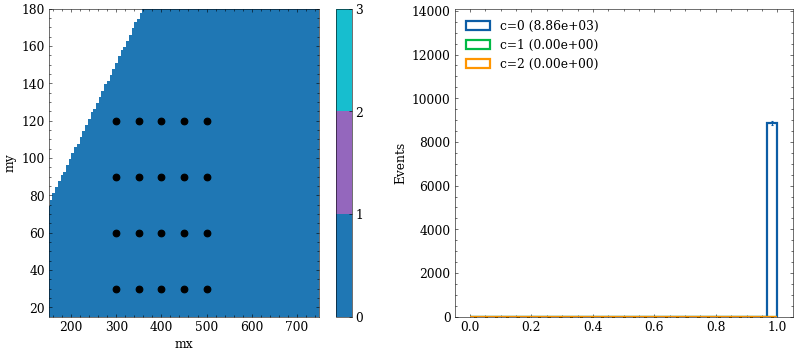

In [32]:
mx = np.linspace(0.5*min(MX), 1.5*max(MX), 100)
my = np.linspace(0.5*min(MY), 1.5*max(MY), 100)

xlim = mx[[0,-1]]
ylim = my[[0,-1]]

mx, my = np.meshgrid(mx, my)
mx, my = mx.flatten(), my.flatten()



with torch.no_grad():
    latent = model.eval().autoencoder.encoder(torch.stack([torch.tensor(mx), torch.tensor(my)], dim=1).float()).numpy()

c, score = latent.argmax(axis=1), latent.max(axis=1)
mask = (mx > 2 * my)
# mask = mask & (score > 0.8)

mx, my, c, score = mx[mask], my[mask], c[mask], score[mask]


fig, axs = study.get_figax(nvar=2)

graph2d_array(
    mx, my, c,
    interp=dict(kind='linear'),
    colorbar=True,
    g_cmap='tab10',
    zlim=np.arange(model.autoencoder.n_emb+1), figax=(fig, axs.flat[0]),
    
)

graph_array(*np.stack(np.meshgrid(MX, MY), axis=0).reshape(2, -1), g_linestyle='none', g_color='black', figax=(fig,axs.flat[0]))
format_axes(axs.flat[0], xlim=xlim, ylim=ylim, xlabel='mx', ylabel='my')

histo_arrays([score[c == i] for i in range(model.autoencoder.n_emb)], figax=(fig, axs.flat[1]), h_histtype='step', h_linewidth=2, h_label=[f'c={i}' for i in range(model.autoencoder.n_emb)], bins=(0, 1, 30), legend=True)


In [33]:
with torch.no_grad():
    (signal+bkg).apply(
        lambda t : t.extend(
            nominal_score=nominal_model.eval().predict( torch.from_numpy(dataset.get_inputs(t)).float() )[:,1].numpy()
        )
    )

In [34]:
predict_section = lambda t, s : model.eval().predict(
            torch.from_numpy(dataset.get_inputs(t)).float(),
            torch.ones(len(t), dtype=torch.int64) * s,
        )[:,1].numpy()

with torch.no_grad():
    (signal+bkg).apply(
        lambda t : t.extend(
        **{
                f'section_{s}_score':predict_section(t, s)
                for s in range(model.autoencoder.n_emb)
            }
        )
    )

100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


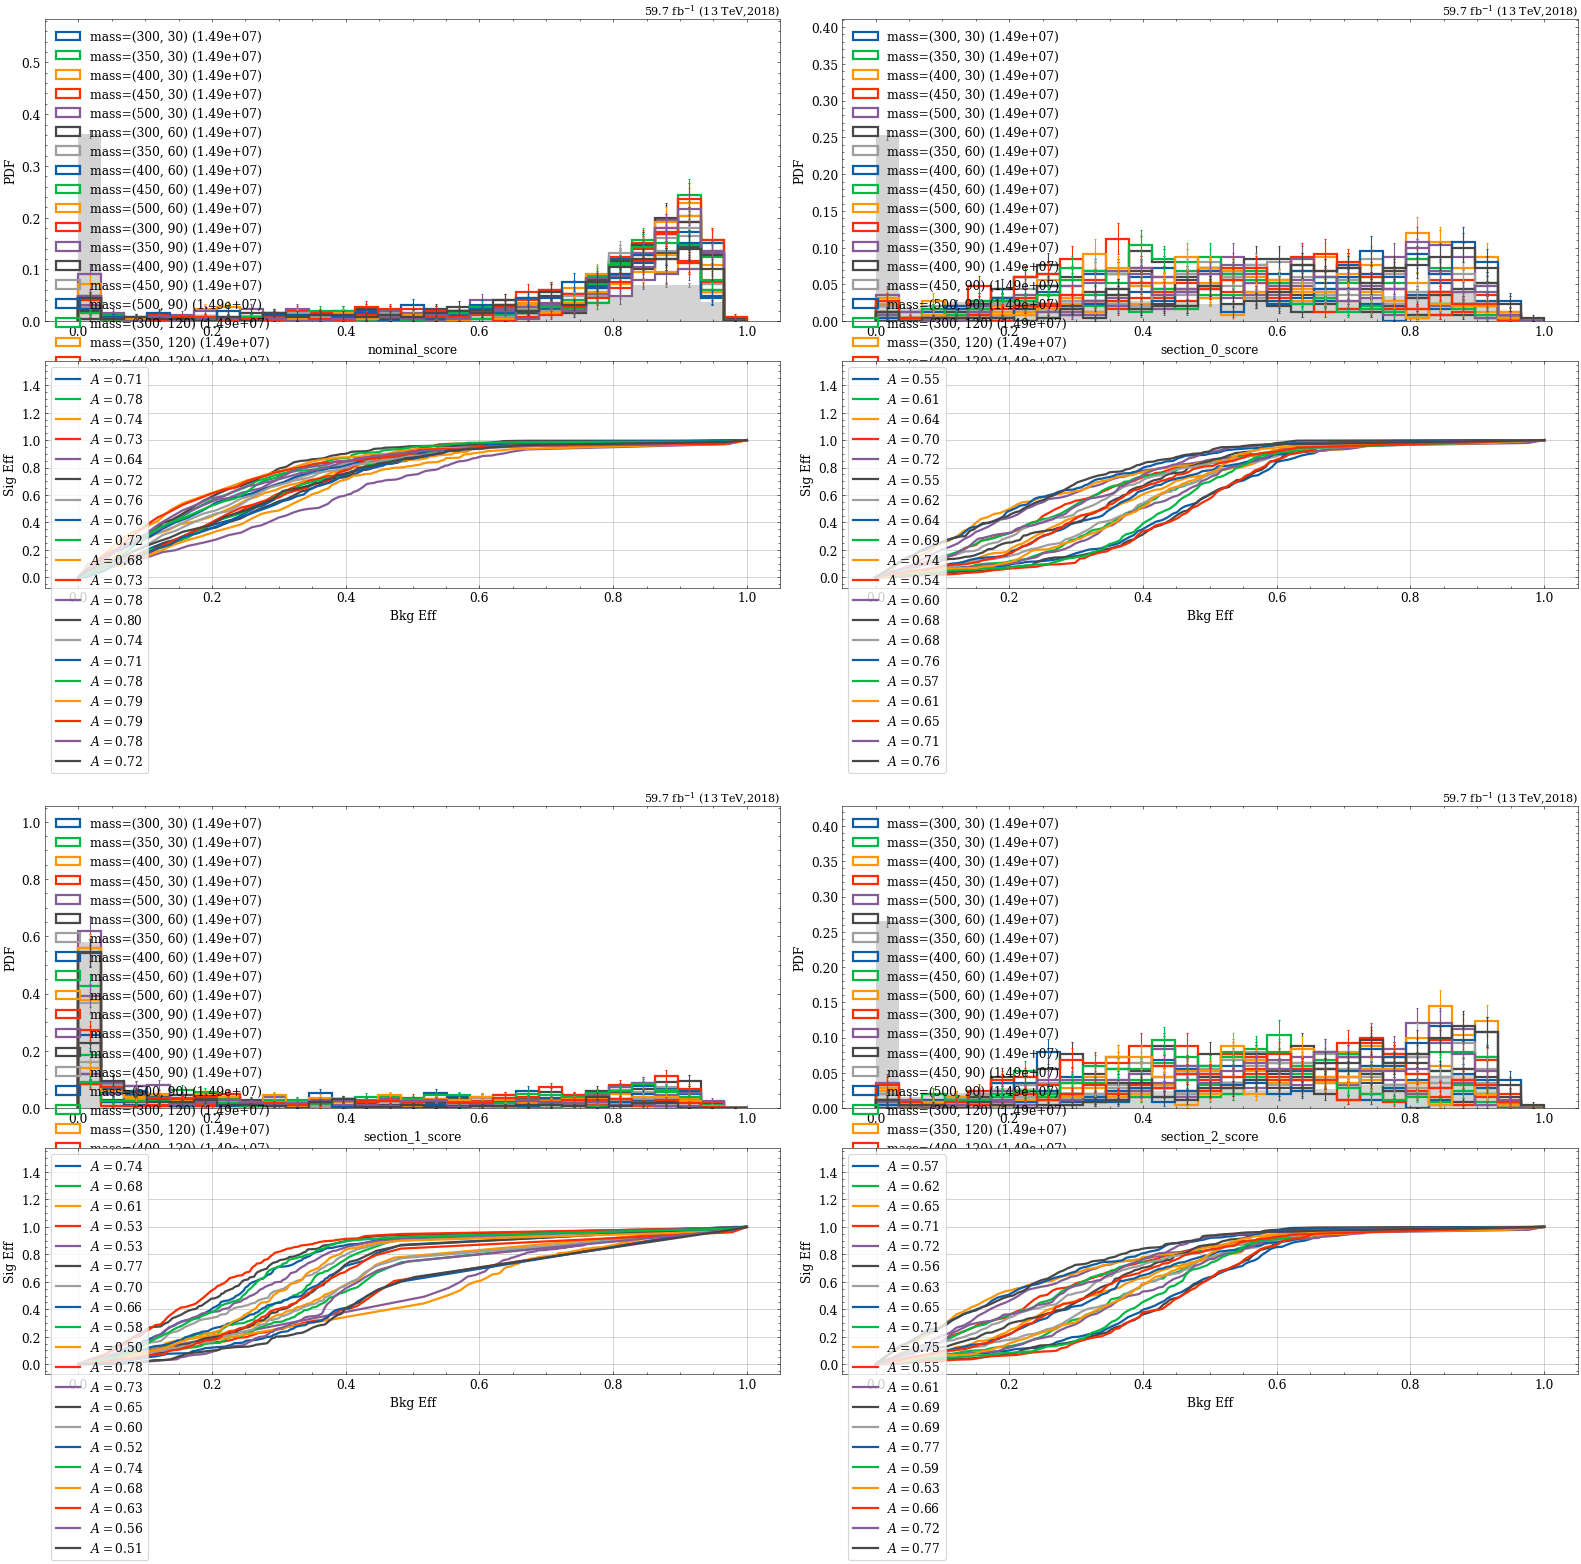

In [35]:
store = obj_store()
study.quick(
    signal + bkg,
    varlist=['nominal_score'] + [f'section_{s}_score' for s in range(model.autoencoder.n_emb)],
    binlist=[(0, 1, 30)] * 100,
    efficiency=True, legend=True,
    **study.auroc,

    e_c_store=store,

    size=(10, 10)
)

In [36]:
def get_info(correlation):
    auroc = correlation.stats.area

    sig = correlation._y_
    label = sig.kwargs['label']

    match = re.match(r'mass=\((\d+), (\d+)\)', label)

    mx = int(match.group(1))
    my = int(match.group(2))

    parameter = torch.tensor([[mx, my]], dtype=torch.float32)
    with torch.no_grad():
        latent = model.eval().autoencoder.encoder(parameter).numpy()

    score = ak.max(latent, axis=1)
    section = ak.where( score > 0.8, ak.argmax(latent, axis=1), 0)

    return dict(
        mx = mx,
        my = my,
        auroc = auroc,
        section = section[0],
        section_score=score[0],
    )

In [37]:
model_auroc = store[0]
section_auroc = store[1:]

nominal = ObjIter(model_auroc).apply(get_info).awk
sections = [ ObjIter(section).apply(get_info).awk for section in section_auroc ]
section_auroc = ak.concatenate([ section.auroc[:,None] for section in sections ], axis=1)
section_index = ak.local_index(section_auroc)

nominal['section_auroc'] = section_auroc[section_index == nominal.section][:,0]
nominal['optimal_section'] = ak.fill_none(ak.argmax(section_auroc, axis=1), np.nan)
nominal['optimal_section_auroc'] = ak.fill_none(ak.max(section_auroc, axis=1), np.nan)

In [38]:
ak.mean(nominal.optimal_section_auroc/nominal.auroc)

0.9680631570284849

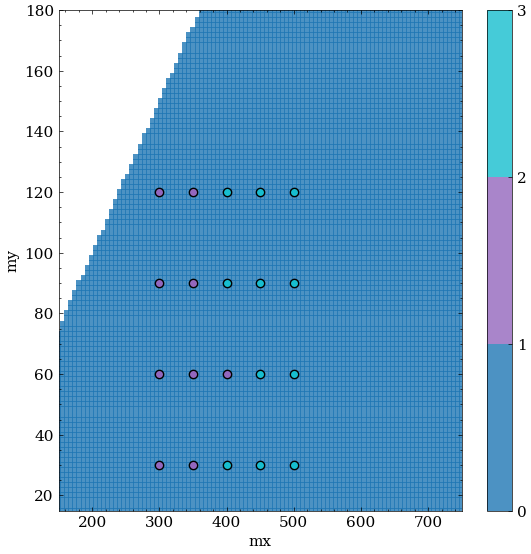

In [39]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots()

graph2d_array(
    mx, my, c,
    interp=dict(kind='linear'),
    colorbar=True,
    g_cmap='tab10',
    g_alpha=0.8,
    zlim=np.arange(model.autoencoder.n_emb+1), figax=(fig, ax),
)

cmap = plt.cm.get_cmap('tab10')
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(model.autoencoder.n_emb+1), ncolors=cmap.N)

for i in range(model.autoencoder.n_emb):
    graph_array(nominal.mx[nominal.optimal_section == i], nominal.my[nominal.optimal_section == i], g_linestyle='none', g_markeredgecolor='black', figax=(fig, ax), g_color=cmap(norm(i)))
format_axes(ax, xlim=mx[[0,-1]], ylim=my[[0,-1]], xlabel='mx', ylabel='my')